In [207]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp
from astropy.table import Table
import camb
from camb import model, initialpower

from numpy import linalg as LA
import utils
from utils import m_l as m_l
from utils import bin_l as bin_l

plt.rcParams['figure.figsize'] = (10.0, 8.0)

# functions

In [56]:
hp.write_map('/smc/jianyao/Ali_maps/ali_mask_wo_wdge_512.fits', ali_ma)

In [2]:
def deconv(maps, beam_in, beam_out, lmax):
    ''' 
    Beam in unit of arc-miniute.
    This function changes the value of the input map itself.
    
    '''
    
    _maps = np.copy(maps)
    for j in range(1,3): ### only for Q\U;
        _maps[j] = hp.sphtfunc.decovlving(_maps[j], fwhm = beam_in/60/180*np.pi, lmax = lmax, verbose = False)
        _maps[j] = hp.smoothing(_maps[j], fwhm = beam_out/60/180*np.pi, lmax = lmax, verbose = False)
    return _maps


def smooth(maps, beam_out, lmax):
    _maps = np.copy(maps);
    for j in range(1,3):                        ###for Q and U. Exclude I.
        _maps[j] = hp.smoothing(_maps[j], fwhm = beam_out/60/180*np.pi, lmax = lmax, verbose = False)
    return _maps

# ali_ma = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/Ali_mask_1024.fits'), nside_out = 512)#, verbose=False)
ali_ma = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits'), nside_out = 512)
def Mask(maps): 
    maps_ma = hp.ma(maps)
    maps_ma.mask = np.logical_not(ali_ma)
    return maps_ma

def Power_spectrum(maps,R, lmax):
    ''' 
    revised for upper-triangle of the matrix.
    Input:
    maps with multi-frequencies IQU sky maps. 
    Galactic plane cut for calculating the power spectrum.
    lmax.  

    Return: EE and BB cross power spectrum. 
    Shape (2, lmax, nf, nf)
    '''
    n_f = len(maps)
    cl = np.ones((2, n_f*n_f, lmax +1)); Cl = np.zeros((2, lmax+1, n_f, n_f))
    k = 0
    for i in range(n_f):
        for j in range(n_f):
            
            if i >= j :
                cross_ps = hp.anafast(maps[i], maps[j], lmax = lmax, gal_cut=R, nspec=3) ## TT, EE, BB
            else:
                cross_ps = np.zeros((3, lmax+1)) 
            cl[0][k] = cross_ps[1]; cl[1][k] = cross_ps[2]  ## calculate the E and B_mode power spectrum 
            k += 1
            
    for l in range(lmax+1):
        Cl[0, l, : , :] = cl[0, :,l].reshape(n_f, n_f); Cl[1, l, : , :] = cl[1, :,l].reshape(n_f, n_f)
        Cl[0, l] += Cl[0, l].T - np.diag(Cl[0, l].diagonal()) ; Cl[1, l] += Cl[1, l].T - np.diag(Cl[1, l].diagonal()) 
    return Cl

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


# Public area

In [299]:
nside = 512; Nf = 4; lmax = 1000; Q = int(lmax/20)

In [139]:
Ell = utils.get_ell(lmax, Q)
el2 = utils.l2(Ell)

In [384]:
Cl_cmb = np.zeros((SamNum,3, lmax + 1))
for n in range(SamNum):
    cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(n), field = None, verbose = False), nside_out = 512)
    cmb_ma = Mask(smooth((cmb_i), beam_out=beam_low, lmax = 1500))
    Cl_cmb[n] = hp.anafast(cmb_ma, lmax = lmax, nspec = 3)

In [385]:
clee_clean_std = utils.bin_l(np.std(Cl_cmb, axis = 0)[1], lmax, Q); clbb_clean_std = utils.bin_l(np.std(Cl_cmb, axis = 0)[2], lmax, Q)
clee_clean = utils.bin_l(np.mean(Cl_cmb, axis = 0)[1], lmax, Q); clbb_clean = utils.bin_l(np.mean(Cl_cmb, axis = 0)[2], lmax, Q)

In [386]:
cl_clean_44_mean = np.row_stack((clee_clean, clbb_clean))
cl_clean_44_std = np.row_stack((clee_clean_std, clbb_clean_std))

In [ ]:
## 95GHz: cl_clean; clean_std

In [449]:
np.save('/fnx/jianyao/cmb_0.05_realizations/cl_clean_95GHz_mean_std.npy', np.row_stack((cl_clean, cl_clean_std)))

# CMB should beamed first, and foreground should downgrade to the same resolution

In [6]:
cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_1.fits', field = None), nside_out = 512)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [377]:
# 13.0765 arcmin, K_CMB
fore70 = hp.ud_grade(hp.read_map('/fnx/jianyao/LFI_070/group2_map_detector_F070.fits', field = None, verbose = False), nside_out = 512)*1e6

#27.9435 arcmin, K_CMB
fore44 = hp.ud_grade(hp.read_map('/fnx/jianyao/LFI_044/group2_map_detector_F044.fits', field = None, verbose = False), nside_out = 512)*1e6

### 19 arcmin, uK_CMB
fore95 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_AliCPT/95GHz/group2_map_95GHz.fits', field = None, verbose = False), nside_out=512)  
### 11 arcmin, uK_CMB
fore150 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_AliCPT/150GHz/group2_map_150GHz.fits', field = None, verbose = False), nside_out=512) 
 ###4.944 arcmin, K_CMB
fore353 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_HFI_353/group2_map_detector_F353.fits', field = None, verbose = False), nside_out=512)*1e6

## single realization

In [10]:
noise_95_i = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_realizations_95GHz_1.fits', field = None, verbose = False),nside_out = 512)
noise_150_i = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_realizations_150GHz_1.fits', field = None, verbose = False),nside_out = 512)
noise_353_i = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/353GHZ_PLA/noise_353_full_map_mc_00001.fits', field = None, verbose = False),nside_out = 512)*1e6

In [11]:
total = np.zeros((Nf, 3, 12*nside**2))
total[0] = smooth(cmb_i, beam_out=19, lmax = 1500) + fore95 + noise_95_i
total[1] = deconv(smooth(cmb_i, beam_out=11, lmax = 1500) + fore150 + noise_150_i, beam_in = 11, beam_out = 19, lmax = 1500)
total[2] = deconv(smooth(cmb_i, beam_out=4.944, lmax = 1500) + fore353 + noise_353_i, beam_in = 4.944, beam_out = 19, lmax = 1500)
total_mask = Mask(total)

In [246]:
Fore = np.zeros((Nf, 3, 12*nside**2))
Fore[0] = fore95
Fore[1] = deconv(fore150, beam_in = 11, beam_out = 19, lmax = 1500)
Fore[2] = deconv(fore353, beam_in = 4.944, beam_out = 19, lmax = 1500)
Fore_mask = Mask(Fore)

In [12]:
Noise = np.zeros((Nf,3,12*nside**2))
Noise[0] = noise_95_i;  
Noise[1] = deconv(noise_150_i, beam_in = 11, beam_out = 19, lmax = 1500) ; 
Noise[2] = deconv(noise_353_i, beam_in = 4.944, beam_out = 19, lmax = 1500)
noise_mask = Mask(Noise)

In [247]:
fore_ps = Power_spectrum(Fore_mask, 0, lmax = lmax)

In [13]:
total_ps_i = Power_spectrum(total_mask, 0, lmax = lmax)
noise_ps_i = Power_spectrum(noise_mask, 0, lmax = lmax)

## Foreground only

In [284]:
sync = np.zeros((Nf, 3, 12*nside**2)); dust = np.zeros((Nf, 3, 12*nside**2))
# uK_CMB
sync_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/95GHz/synchrotron_map_95GHz.fits', field = (0,1,2), verbose = False), nside_out=512)
sync_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/150GHz/synchrotron_map_150GHz.fits', field = (0,1,2), verbose = False), nside_out=512)
#K_CMB
sync_353 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_skyinband_HFI_353/detector_F353/synchrotron_map_detector_F353.fits', field = (0,1,2), verbose = False), nside_out=512)*1e6 

sync[0] = smooth(sync_95, beam_out=11, lmax = 1500)
sync[1] = smooth(sync_150, beam_out=11, lmax = 1500)
sync[2] = smooth(sync_353, beam_out=11, lmax = 1500)

In [291]:
dust = np.zeros((Nf, 3, 12*nside**2))
# uK_CMB
dust_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/95GHz/thermaldust_map_95GHz.fits', field = (0,1,2), verbose = False), nside_out=512)
dust_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_skyinband_AliCPT/150GHz/thermaldust_map_150GHz.fits', field = (0,1,2), verbose = False), nside_out=512)
#K_CMB
dust_353 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_skyinband_HFI_353/detector_F353/thermaldust_map_detector_F353.fits', field = (0,1,2), verbose = False), nside_out=512)*1e6 

dust[0] = smooth(dust_95, beam_out=11, lmax = 1500)
dust[1] = smooth(dust_150, beam_out=11, lmax = 1500)
dust[2] = smooth(dust_353, beam_out=11, lmax = 1500)

In [292]:
sync_ps = Power_spectrum(Mask(sync), 0, lmax = lmax)
dust_ps = Power_spectrum(Mask(dust), 0, lmax = lmax)

## Save 100 realizations total maps

In [381]:
SamNum =100; beam_low = 27.9435; Nf = 4

for i in range(SamNum):
    if i < 50:
        noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_realizations_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
        noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_realizations_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
    else: 
        noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
        noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
    
    # K_CMB, nside = 1024, IQU
#     noise_70 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/70GHz_LFI/70GHz_LFI_noise_070_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
    noise_44 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/44GHz_LFI/noise_044_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
    noise_353 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/353GHZ_PLA/noise_353_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
    
    Noise = np.zeros((Nf,3,12*nside**2))
    Noise[0] = noise_44;
    Noise[1] = deconv(noise_95, beam_in = 19, beam_out = beam_low, lmax = lmax + 100);  
    Noise[2] = deconv(noise_150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100); 
    Noise[3] = deconv(noise_353, beam_in = 4.944, beam_out = beam_low, lmax = lmax + 100);
    noise_ps_i = utils.Power_spectrum(Mask(Noise), 0, lmax = lmax);
    np.save('/fnx/jianyao/ancillary_data/4_fre_plus_44/noise_ps/nl_deconv_masked_EB_%s.npy'%i, noise_ps_i)
    
    cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(i), field = None, verbose = False), nside_out = 512)
    
    total = np.zeros((Nf, 3, 12*nside**2))
    total[0] = smooth(cmb_i, beam_out = beam_low, lmax = lmax + 100) + fore44 + noise_44
    total[1] = deconv(smooth(cmb_i, beam_out = 19, lmax = lmax + 100) + fore95 + noise_95, beam_in = 19, beam_out = beam_low, lmax = lmax + 100)
    total[2] = deconv(smooth(cmb_i, beam_out=11, lmax = lmax + 100) + fore150 + noise_150, beam_in = 11, beam_out = beam_low, lmax = lmax + 100)
    total[3] = deconv(smooth(cmb_i, beam_out=4.944, lmax = lmax + 100) + fore353 + noise_353, beam_in = 4.944, beam_out = beam_low, lmax = lmax + 100)
    
    np.save('/fnx/jianyao/ancillary_data/4_fre_plus_44/total_map_unmasked/total_map_deconv_unmasked_IQU_%03d.npy'%i, total)
    total_mask = Mask(total)
    
    total_ps_i = utils.Power_spectrum(total_mask, 0, lmax = lmax)
    np.save('/fnx/jianyao/ancillary_data/4_fre_plus_44/total_ps/total_ps_deconv_masked_EB_%s.npy'%i, total_ps_i)

# ILC

## ILC in harmonic space

### ILC implemented

In [410]:
Nf = 4

In [444]:
SamNum = 100 ## just one realization , or all the realizations.
Cl_ilc = np.zeros((SamNum, Q)); itera = 1; mode = 1; Fore_cl= np.zeros((SamNum, Q)); sync_cl = np.zeros((SamNum, Q)); dust_cl = np.zeros((SamNum, Q))
for n in range(SamNum): 

    e = np.matrix(np.ones(Nf))
    total_ps_i = np.load('/fnx/jianyao/ancillary_data/4_fre_plus_44/total_ps/total_ps_deconv_masked_EB_%s.npy'%n)
    noise_ps_i = np.load('/fnx/jianyao/ancillary_data/4_fre_plus_44/noise_ps/nl_deconv_masked_EB_%s.npy'%n)
    ## Power_spectrum return EE and BB at the same time. So total_ps[0] = EE; total_ps[1] = BB
    noise_bin = utils.bin_l(noise_ps_i[mode], lmax, Q); 
    noise_ilc = np.zeros(Q); 
    total_bin = utils.bin_l(total_ps_i[mode], lmax, Q);
    fore_bin = utils.bin_l(fore_ps[mode], lmax, Q); sync_bin = utils.bin_l(sync_ps[mode], lmax, Q); dust_bin = utils.bin_l(dust_ps[mode], lmax, Q);

    for r in range(itera):
        if r == 0:
            nuisance = noise_bin
            
        else:
            nuisance = total_bin - All_matrix(Cl_ilc[n], Nf)
            
        #calculate the weight
        W = np.matrix(np.zeros((Q, Nf)))
        noise_clean = np.zeros(Q)                                 ## to get the std of ILC CMB
        for l in range(Q):
            norm = e*np.linalg.pinv((total_bin[l]))*e.T
            noise_clean[l] = e*np.linalg.pinv(noise_bin[l])*e.T   ## to get the std of ILC CMB
            W[l,:] = e*np.linalg.pinv((total_bin[l]))/norm   
        
        for i in range(Q):
            
            ''' whether include noise_bin or not;  WNW = 1/(eN{-1}e.T)'''
            
            noise_ilc[i] = W[i,:]*(nuisance[i])*np.transpose(W[i,:])     #noise_bin　nuisance[i]
            Cl_ilc[n, i] = W[i,:]*(total_bin[i])*np.transpose(W[i,:]) - noise_ilc[i]  #1.0/(e*np.linalg.pinv((total_bin[i]))*e.T) 
#             Fore_cl[n, i] =  W[i,:]*(fore_bin[i])*np.transpose(W[i,:]);
#             dust_cl[n, i] = W[i,:]*(dust_bin[i])*np.transpose(W[i,:]); sync_cl[n,i] = W[i,:]*(sync_bin[i])*np.transpose(W[i,:]);

#     total = np.load('/fnx/jianyao/ancillary_data/total_map/total_map_deconv_unmasked_IQU_%03d.npy'%n)
#     total_mask = Mask(total)
    
#     ### ILC results to cleaned CMB maps
#     alm_Q = np.zeros((Nf, m_num), dtype = 'complex128'); alm_U = np.zeros((Nf, m_num), dtype = 'complex128')

#     for i in range(Nf):
#         alm_Q[i] = hp.map2alm(total_mask[i], lmax = lmax-1)[1]; # 95GHz, 150GHz, 353GHz
#         alm_U[i] = hp.map2alm(total_mask[i], lmax = lmax-1)[2]; 
    
#     alm_Q_clean = np.zeros(m_num,dtype = 'complex128'); alm_U_clean = np.zeros(m_num, dtype = 'complex128')

#     for l in np.arange(lmax):
#         alm_Q_clean[m_l(lmax - 1, l)] = np.dot(np.array(W[l, :]),alm_Q[:,m_l(lmax - 1, l)])[0] #np.dot(np.array(weight[l, :]),alm_Q[:,m_l(lmax, l)])[0]#
#         alm_U_clean[m_l(lmax - 1, l)] = np.dot(np.array(W[l, :]),alm_U[:,m_l(lmax - 1, l)])[0]

#     alm_Q_clean[m_l(lmax, 0)] = 0; alm_Q_clean[m_l(lmax, 1)] = 0
#     alm_U_clean[m_l(lmax, 0)] = 0; alm_U_clean[m_l(lmax, 1)] = 0
    
#     almT = np.zeros_like(alm_Q_clean)
#     cmb_clean = hp.alm2map(np.row_stack((almT, alm_Q_clean, alm_U_clean)), nside = nside, lmax = lmax - 1)
    
#     hp.write_map('/fnx/jianyao/HS_clean_CMB/Cleaned_QU_%03d.fits'%(n),cmb_clean[1:], coord='G', column_names= names, column_units='uK_CMB')

# fore_mean = np.mean(Fore_cl, axis=0)
cl_ilc_mean = np.mean(Cl_ilc, axis = 0)
cl_ilc_std = np.std(Cl_ilc, axis = 0)

In [294]:
sync_mean = np.mean(sync_cl, axis = 0)
dust_mean = np.mean(dust_cl, axis = 0)

Text(0.5, 1.0, 'ILC BB ps')

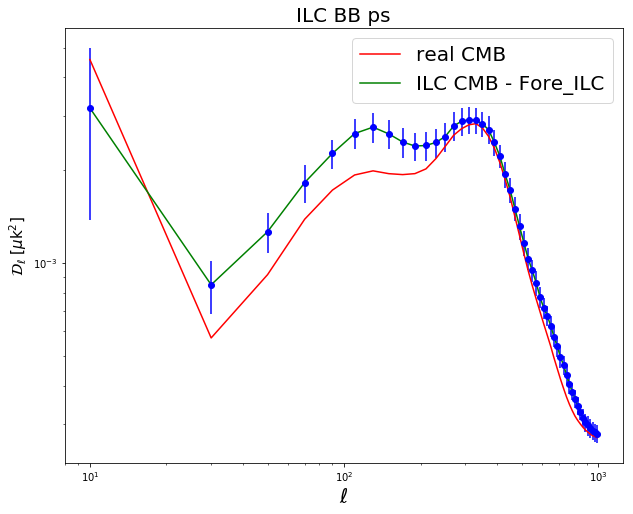

In [445]:
fig1 = plt.figure(1, figsize=(10,8))
# plt.axis('off')
# frame1=fig1.add_axes((.1,.4,.8,.5)) # x0, y0, width, height
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*cl_clean_44_mean[mode] , 'r-',label = 'real CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*(cl_ilc_mean ), 'g-', label = 'ILC CMB - Fore_ILC')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*noise_ilc, 'k--', label = 'noise_beamed_ilc')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*fore_mean, 'b--', label = 'Fore_ilc_residual')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*dust_mean, 'y--', label = 'Dust_ILC')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*sync_mean, 'k--', label = 'Synchrotron_ILC')


# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(total_cl95[mode+1], lmax, Q), 'purple', label = 'total_ps 95GHz')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(total_cl150[mode+1], lmax, Q), 'orange', label = 'total_ps 150GHz')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*bin_l(total_cl353[mode+1], lmax, Q), 'k-', label = 'total_ps 353GHz')

# plt.xscale('linear')
plt.errorbar(Ell,Ell*(Ell+1)*cl_ilc_mean/2/np.pi, yerr = Ell*(Ell+1)/2/np.pi*cl_ilc_std,fmt='bo',capthick = 0.1)
# plt.ylim(1e-4, 1e-1)
plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20)
# plt.title('ILC in harmonical space, subtracting %s * dust'%frac, fontsize = 20)

# frame2=fig1.add_axes((.1,.1,.8,.3))
# plt.semilogx(Ell, (cl_ilc - cls)/cls*100, 'k--')
# plt.axhline(0,color = 'k')
# plt.ylabel(r'$\Delta \mathcal{D}_\ell$/$\mathcal{D}^{real}_{\ell} $ [%]', fontsize = 15);plt.xlabel(r'$\ell$', fontsize = 20)
# plt.ylim(-100, 100)
plt.title('ILC %s ps'%psn[mode], fontsize = 20)
# plt.savefig('/home/jianyao/Ali_maps/results/0225_4fre_ABS_ILC/EE_ILC_with_77GHz.jpg', format = 'jpg')

In [174]:
total_cl150 = hp.anafast(total_mask[1]); total_cl353 = hp.anafast(total_mask[2])

In [172]:
total_cl95 = hp.anafast(total_mask[0])

### ILC cleand maps

In [38]:
m_num = int((1 + lmax)*(lmax+1 -1)/2) # the number of alm of lmax=l for m >= 0; m = 0,1 for l = 1; m = 0,1,2 for l = 2.
alm_Q = np.zeros((Nf, m_num), dtype = 'complex128'); alm_U = np.zeros((Nf, m_num), dtype = 'complex128')

for i in range(Nf):
    alm_Q[i] = hp.map2alm(total_mask[i], lmax = lmax-1)[1]; # 95GHz, 150GHz, 353GHz
    alm_U[i] = hp.map2alm(total_mask[i], lmax = lmax-1)[2]; 

In [39]:
alm_Q_clean = np.zeros(m_num,dtype = 'complex128'); alm_U_clean = np.zeros(m_num, dtype = 'complex128')

for l in np.arange(lmax):
    alm_Q_clean[m_l(lmax - 1, l)] = np.dot(np.array(W[l, :]),alm_Q[:,m_l(lmax - 1, l)])[0] #np.dot(np.array(weight[l, :]),alm_Q[:,m_l(lmax, l)])[0]#
    alm_U_clean[m_l(lmax - 1, l)] = np.dot(np.array(W[l, :]),alm_U[:,m_l(lmax - 1, l)])[0]
    
alm_Q_clean[m_l(lmax, 0)] = 0; alm_Q_clean[m_l(lmax, 1)] = 0
alm_U_clean[m_l(lmax, 0)] = 0; alm_U_clean[m_l(lmax, 1)] = 0

In [40]:
# Q_clean = hp.alm2map(alm_Q_clean, nside = nside, lmax = lmax - 1); U_clean = hp.alm2map(alm_U_clean, nside = nside, lmax = lmax - 1);
# I_clean = np.zeros_like(Q_clean)
almT = np.zeros_like(alm_Q_clean)
cmb_clean = hp.alm2map(np.row_stack((almT, alm_Q_clean, alm_U_clean)), nside = nside, lmax = lmax - 1)
# alm_total = hp.map2alm(cmb_clean)
# B_maps = hp.alm2map(alm_total[2], nside = nside, verbose = False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [41]:
cls_final = hp.anafast(Mask(cmb_clean), nspec=3, lmax = lmax)
# cls_final = hp.alm2cl(alm_U_clean)

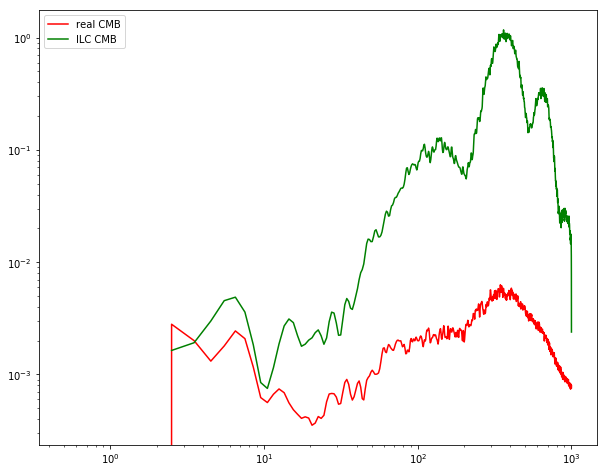

In [44]:
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*clbb_clean, 'r-',label = 'real CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*(cls_final[1][:lmax] - noise_ilc), 'g-', label = 'ILC CMB')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*noise_ilc, 'b--', label = 'noise_ilc')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*total_cl[2], 'k--', label = 'total_ps')

plt.legend()

In [193]:
cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(0), field = None, verbose = False), nside_out = 512)
cmb_ma = Mask(smooth((cmb_i), beam_out=19, lmax = 1500))

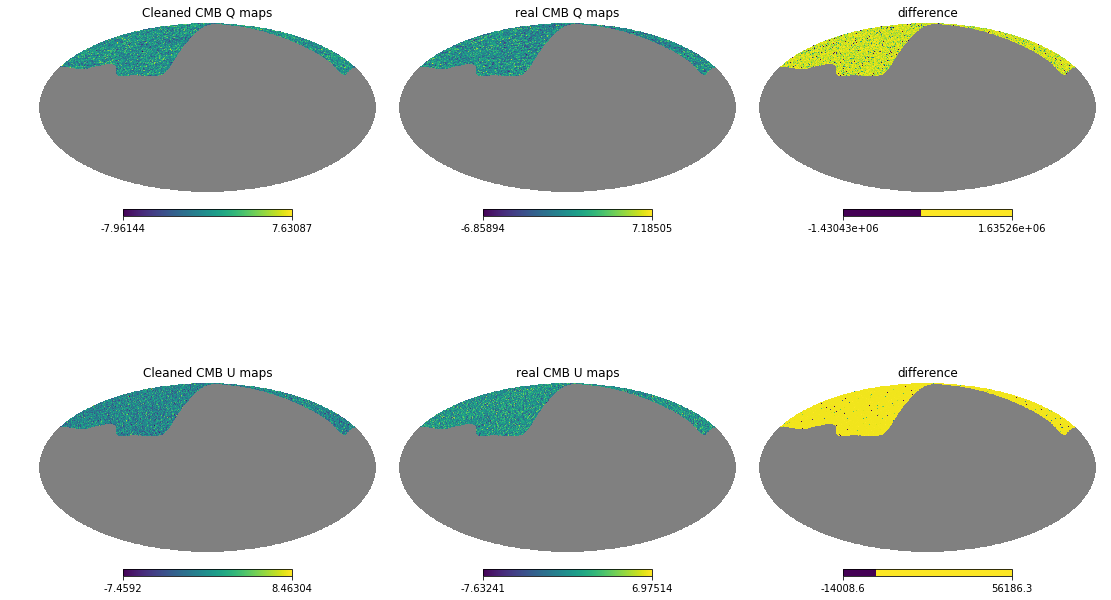

In [200]:
plt.figure(figsize = (15,10))
hp.mollview(Mask(cmb_clean[1]), sub = (231), title = 'Cleaned CMB Q maps'); 
hp.mollview(cmb_ma[1], sub = (232), title = 'real CMB Q maps')

hp.mollview((cmb_ma[1] - Mask(cmb_clean[1]))/Mask(cmb_clean[1])*100 , sub = (233), title = 'difference', norm = 'hist')


hp.mollview(Mask(cmb_clean[2]), sub = (234), title = 'Cleaned CMB U maps'); 
hp.mollview(cmb_ma[2], sub = (235), title = 'real CMB U maps')
hp.mollview((cmb_ma[2] - Mask(cmb_clean[2]))/Mask(cmb_clean[2]), sub = (236), title = 'difference', norm = 'hist')

plt.savefig('/home/jianyao/Ali_maps/results/0212/Cleaned_maps_QU.png', format = 'png')

In [ ]:
# COMPONENT GROUP 1: cmb                                                                                                                                                                                                                     
# COMPONENT GROUP 2: synchrotron freefree thermaldust spindust co
# COMPONENT GROUP 3: faintradiops faintirps thermalsz firb
# COMPONENT GROUP 4: strongirps strongradiops

## ILC in pixel space

In [62]:
index = np.arange(12*nside**2)
mask_index = index[ali_ma == 1]

In [227]:
Cl_ilc_rs = np.zeros((2, SamNum, Q)); # E and B mode together 
Nl_ilc_rs = np.zeros((2, SamNum, Q))

for n in range(SamNum):
   
    total = np.load('/fnx/jianyao/ancillary_data/total_map/total_map_deconv_unmasked_IQU_%03d.npy'%n)
    total_mask = Mask(total)
    
    total_Q = np.zeros((Nf, 12*nside**2)) ; total_U = np.zeros((Nf, 12*nside**2))## two frequencies
    noise_Q = np.zeros((Nf, 12*nside**2)); noise_U= np.zeros((Nf, 12*nside**2))

    for i in range(Nf):
        total_Q[i][mask_index] = total_mask[i][1][mask_index]
        total_U[i][mask_index] = total_mask[i][2][mask_index]

        # noise_ILC
        noise_Q[i][mask_index] = noise_mask[i][1][mask_index]
        noise_U[i][mask_index] = noise_mask[i][2][mask_index]

    Cov_Q = np.zeros((Nf, Nf)); w_Q = np.zeros(Nf)
    Cov_U = np.zeros((Nf, Nf)); w_U = np.zeros(Nf)

    for i in range(Nf):
        for j in range(Nf):
            Cov_Q[i, j] = np.dot(total_Q[i][mask_index] - np.mean(total_Q[i][mask_index]), total_Q[j][mask_index] - np.mean(total_Q[j][mask_index]))/1.0/len(mask_index)
            Cov_U[i, j] = np.dot(total_U[i][mask_index] - np.mean(total_U[i][mask_index]), total_U[j][mask_index] - np.mean(total_U[j][mask_index]))/1.0/len(mask_index)

    Cov_Q_inv = np.linalg.pinv(Cov_Q)
    Cov_U_inv = np.linalg.pinv(Cov_U)


    for i in range(Nf):
        w_Q[i] = np.sum(Cov_Q_inv[i,:])/np.sum(Cov_Q_inv)
        w_U[i] = np.sum(Cov_U_inv[i,:])/np.sum(Cov_U_inv)


    cmb_Q = np.dot(w_Q, total_Q); cmb_U = np.dot(w_U, total_U)
    
#     cmb_QU = np.row_stack((cmb_Q, cmb_U))
#     hp.write_map('/fnx/jianyao/RS_clean_CMB/RS_Cleaned_QU_%03d.fits'%(n),cmb_QU, coord='G', column_names= names, column_units='uK_CMB')

    cmb_I = np.zeros_like(cmb_Q);
    cmb_ILC_pix = np.row_stack((cmb_I, cmb_Q, cmb_U))

    noise_ilc_q = np.dot(w_Q, noise_Q); noise_ilc_u = np.dot(w_U, noise_U)
    noise_I = np.zeros_like(noise_ilc_q)
    noise_ilc_pix = np.row_stack((noise_I, noise_ilc_q, noise_ilc_u))
    
    cls_ILC_pix = hp.anafast(cmb_ILC_pix, lmax = lmax, nspec = 3)
    nl_ilc_pix = hp.anafast(noise_ilc_pix, lmax = lmax, nspec = 3)
    
    Cl_ilc_rs[0,n] = bin_l(cls_ILC_pix[1], lmax, Q); Cl_ilc_rs[1,n]  = bin_l(cls_ILC_pix[2], lmax, Q)
    Nl_ilc_rs[0,n] = bin_l(nl_ilc_pix[1], lmax, Q); Nl_ilc_rs[1,n] = bin_l(nl_ilc_pix[2], lmax, Q)
    

### ILC power spectrum

In [231]:
mode = 0
cl_ilc_rs_mean = np.mean(Cl_ilc_rs[mode], axis = 0); nl_ilc_rs_mean = np.mean(Nl_ilc_rs[mode], axis = 0)
cl_ilc_rs_std = np.std(Cl_ilc_rs[mode], axis = 0); nl_ilc_rs_std = np.std(Nl_ilc_rs[mode], axis = 0)

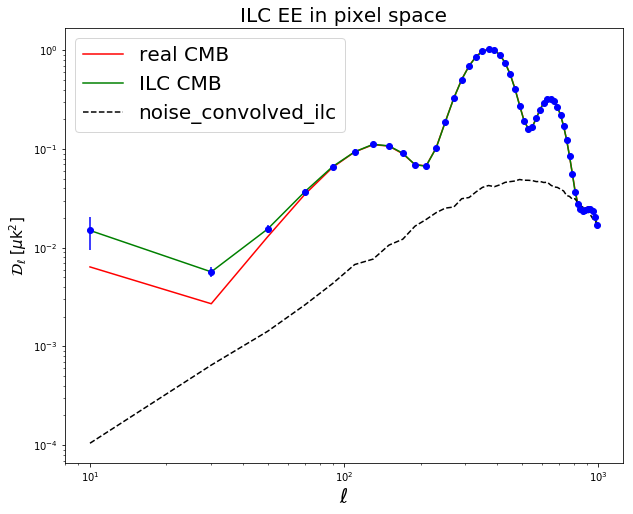

In [232]:
psn = ['EE', 'BB']
fig1 = plt.figure(1, figsize=(10,8))
# plt.axis('off')
# frame1=fig1.add_axes((.1,.4,.8,.5)) # x0, y0, width, height
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*cl_clean[mode], 'r-',label = 'real CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*(cl_ilc_rs_mean - nl_ilc_rs_mean), 'g-', label = 'ILC CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*nl_ilc_rs_mean, 'k--', label = 'noise_convolved_ilc')

plt.errorbar(Ell,Ell*(Ell+1)*(cl_ilc_rs_mean - nl_ilc_rs_mean)/2/np.pi, yerr = Ell*(Ell+1)/2/np.pi*cl_ilc_rs_std,fmt='bo',capthick = 0.1)

plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20)
plt.title('ILC %s in pixel space'%psn[mode], fontsize = 20)

# frame2=fig1.add_axes((.1,.1,.8,.3))
# plt.semilogx(Ell, (cl_ilc - cls)/cls*100, 'k--')
# plt.axhline(0,color = 'k')
# plt.ylabel(r'$\Delta \mathcal{D}_\ell$/$\mathcal{D}^{real}_{\ell} $ [%]', fontsize = 15);plt.xlabel(r'$\ell$', fontsize = 20)
# plt.ylim(-100, 100)
plt.savefig('/home/jianyao/Ali_maps/results/0221_ILC_pixel/ILC_pixel_%s.jpg'%psn[mode], format = 'png')

# ABS

## noise mean ps and std

In [439]:
nl_all_bin = np.ones((SamNum, 2, Q, Nf, Nf))
for i in range(SamNum):
    noise_ps_i = np.load('/fnx/jianyao/ancillary_data/4_fre_plus_44/noise_ps/nl_deconv_masked_EB_%s.npy'%i)
    nl_all_bin[i, 0] = bin_l(noise_ps_i[0], lmax, Q); nl_all_bin[i, 1] = bin_l(noise_ps_i[1], lmax, Q)
    
nl_bin_mean = np.mean(nl_all_bin, axis = 0); nl_bin_std = np.std(nl_all_bin, axis = 0)

In [420]:
nl_bin_std.shape

(2, 50, 4, 4)

## ABS main 

In [446]:
D_B = np.zeros((SamNum, Q)); s = 5.00827749e-5; Delta = 10*s;
##  mode = 0 for EE or 1 for BB mode
for n in range(SamNum):
    total_ps = np.load('/fnx/jianyao/ancillary_data/4_fre_plus_44/total_ps/total_ps_deconv_masked_EB_%s.npy'%n)
    D_B_n = np.zeros(Q);
    
    D = utils.bin_l(total_ps[mode],lmax,Q); f = []; Evals = np.ones((Q,Nf)); E_cut = 1
    sigmaD = np.zeros(Q)
    
    for i in range(Q):
        f_q = np.ones(Nf)
        for j in range(Nf):
            f_q[j] = f_q[j]/np.sqrt(nl_bin_std[mode][i][j, j])   ##nl_std_all.shape = (2, Q, Nf, Nf)
        f.append(f_q) 

    for l in range(Q):
        D[l] = D[l] - nl_bin_mean[mode][l] 
        for i in range(Nf): 
            for j in range(Nf):
                D[l][i,j] = D[l][i,j]/np.sqrt(nl_bin_std[mode][l][i, i]*nl_bin_std[mode][l][j, j]) + Delta*f[l][i]*f[l][j] 

    for l in range(0,Q): 
        e_vals,E = LA.eig(D[l])
        Evals[l,:] = e_vals        

        for i in range(Nf):
            E[:,i]=E[:,i]/LA.norm(E[:,i])**2  

        D_B_l = 0; sigmaD_l = 0; G = np.ones(Nf)
        for i in range(Nf):
            if e_vals[i]>=E_cut:
                G_i = np.dot(f[l],E[:,i])
                D_B_l += (G_i**2/e_vals[i])

        D_B_l = 1.0/ D_B_l - Delta
        D_B_n[l] = D_B_l

        ### Calculate the theoretical error of ABS method using perturbation theory...
        for i in range(Nf):
            G[i]= np.dot(f[l],E[:,i])
            sigmaD[l] += (G[i]**2/e_vals[i]**2)*(clbb_clean[l] + Delta)**2
        
        ## for C_alpha
        if l == Q-11:
            evals_test = e_vals
            con_i = np.ones(Nf)
            for i in range(Nf):
                G_test= np.dot(f[l],E[:,i])
                con_i[i] = (G_test**2/e_vals[i])
    
            for i in range(Nf):
                con_i[i] = con_i[i]/np.sum(con_i)
        
    D_B[n] = D_B_n
    
D_B_mean = np.mean(D_B, axis = 0)
D_B_std = np.std(D_B, axis = 0)

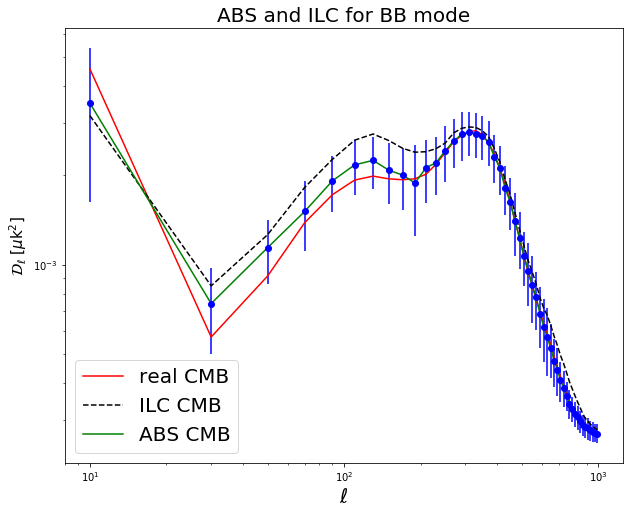

In [447]:
fig1 = plt.figure(1, figsize=(10,8))
# plt.axis('off')
# frame1=fig1.add_axes((.1,.4,.8,.5)) # x0, y0, width, height
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*cl_clean_44_mean[mode], 'r-',label = 'real CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*(cl_ilc_mean), 'k--', label = 'ILC CMB ')

plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*(D_B_mean), 'g-', label = 'ABS CMB')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*nl_ilc_rs_mean, 'k--', label = 'noise_convolved_ilc')

plt.errorbar(Ell,Ell*(Ell+1)*(D_B_mean)/2/np.pi, yerr = Ell*(Ell+1)/2/np.pi*D_B_std,fmt='bo',capthick = 0.1)
# plt.errorbar(Ell,Ell*(Ell+1)*cl_ilc_mean/2/np.pi, yerr = Ell*(Ell+1)/2/np.pi*cl_ilc_std,fmt='yo',capthick = 0.1)


plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20)
plt.title('ABS and ILC for %s mode'%psn[mode], fontsize = 20)
plt.savefig('/home/jianyao/Ali_maps/results/0225_4fre_ABS_ILC/%s_4fre_44_ILC_ABS.jpg'%psn[mode], format = 'jpg')

# Writing into fits file

In [30]:
names = ['Q_polarization', 'U_polarization']

In [33]:
hp.write_map('/fnx/jianyao/HS_clean_CMB/Cleaned_QU_%03d.fits'%(1),cmb_clean[1:], coord='G', column_names= names, column_units='uK_CMB')

In [34]:
clean_test = hp.read_map('/fnx/jianyao/HS_clean_CMB/Cleaned_QU_%03d.fits'%(1), h = True, field = None)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [29]:
cmb_clean[1:].shape

(2, 3145728)

# Calculate the PS of noise and total_ps

In [164]:
## To generate one realization of noise maps. 

n3test = hp.read_map('/smc/jianyao/Ali_maps/Noise_maps/fits/I_Noise_150_G_1024.fits', partial=True)
n3zeros = n3test*0 #0,0,nan,nan......
nIQU = np.zeros((3, len(n3test)))
index = np.arange(len(n3test))#index[n2zeros == 0]
# for i in index[n2test <= 5]:
SamNum = 50
for n in range(50, 50+SamNum):
    
    for i in index[n3zeros==0]:#[n3zeros==0]:    #full_ali map, without mask out the edge.
        nIQU[0][i] = np.random.normal(0, n3test[i])
        nIQU[1][i] = np.random.normal(0, n3test[i]*np.sqrt(2))
        nIQU[2][i] = np.random.normal(0, n3test[i]*np.sqrt(2))

    hp.write_map('/fnx/jianyao/Noise_realizations/150GHz/noise_150GHz_%s.fits'%(n), nIQU)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
